# Notebook to run differential expression analysis using ´MAST´

**Created by** : **Srivalli Kolla**

**Devloped on** : July 19,2024 

**Last Modified** : July 19,2024 

**Institute of Systems Immunology, University of Wurzburg**

# Importing packages

In [2]:
import os
import scanpy as sc
import pandas as pd
import sc_toolbox
import scipy.io
import scanpy as sc
import matplotlib.pyplot as plt
import scipy.sparse as sparse
from rpy2 import robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr

pandas2ri.activate()

MAST = importr('MAST')


Installed version 0.12.1 of sc-toolbox is outdated. Newest version is 0.12.3!

In [3]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 300, color_map = 'RdPu', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.8.0
scanpy      1.9.3
-----
PIL                 8.2.0
adjustText          1.2.0
argcomplete         NA
attr                23.2.0
backcall            0.2.0
backports           NA
backports_abc       NA
beta_ufunc          NA
binom_ufunc         NA
cffi                1.15.1
cloudpickle         2.2.1
colorama            0.4.6
cycler              0.10.0
cython_runtime      NA
dask                2022.02.0
dateutil            2.9.0
debugpy             1.6.3
decorator           5.1.1
entrypoints         0.4
fsspec              2023.1.0
h5py                3.7.0
ipykernel           6.16.2
ipython_genutils    0.2.0
jedi                0.19.1
jinja2              3.1.4
joblib              1.3.2
kiwisolver          1.4.4
llvmlite            0.39.1
markupsafe          2.1.5
matplotlib          3.5.3
more_itertools      NA
mpl_toolkits        NA
natsort             8.4.0
nbinom_ufunc        NA
numba               0.56.3
numpy               1.21.6
packaging           23.2
panda

# MAST

## Data Preparation

##### Steps followed

1. Data loading and subsetting
2. Normalization and log transformation
3. Generating individual files for genes, barcodes, metadata and a matrix having log counts

In [4]:
adata = sc.read_h5ad('/home/skolla/Github/hofmann_dmd/hofmann_dmd/data/DMD-MdxSCID_CMC-Immune_ctl240711.log.h5ad')

desired_cell_states = ['vCM1', 'vCM2', 'vCM3', 'vCM4']
adata = adata[adata.obs['cell_states'].isin(desired_cell_states)]


sc.pp.filter_genes(adata, min_counts=10)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)


sparse_matrix = sparse.csr_matrix(adata.X.T)
scipy.io.mmwrite('/home/skolla/Github/hofmann_dmd/hofmann_dmd/DE/de_results/mdxscid_matrix.mtx', sparse_matrix)
genes = pd.DataFrame(adata.var.index, columns=["gene"])
genes.to_csv('/home/skolla/Github/hofmann_dmd/hofmann_dmd/DE/de_results/mdxscid_genes.tsv', sep='\t', index=False, header=False)
barcodes = pd.DataFrame(adata.obs.index, columns=["barcode"])
barcodes.to_csv('/home/skolla/Github/hofmann_dmd/hofmann_dmd/DE/de_results/mdxscid_barcodes.tsv', sep='\t', index=False, header=False)
metadata = adata.obs
metadata.to_csv('/home/skolla/Github/hofmann_dmd/hofmann_dmd/DE/de_results/mdxscid_metadata.tsv', sep='\t', index=True, header=True)

filtered out 2592 genes that are detected in less than 10 counts
normalizing counts per cell
    finished (0:00:00)


/home/skolla/miniforge3/envs/mast_env/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:249: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_counts'] = number
/home/skolla/miniforge3/envs/mast_env/lib/python3.7/contextlib.py:119: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


## Defining Functions

##### Steps followed in defining functions

*Create_single_cell_assay*

For creating a single cell assay object which can be used by MAST for differential gene expression

1. Read the matrix, genes, and barcodes files
2. Ensure the matrix has correct row and column names by checking with colnames and riownames of matrix
3. Convert sparse matrix to dense matrix
4. Ensure metadata matches the expression matrix
5. Create the SingleCellAssay object
6. Compute number of expressed genes per cell and store as a column in sca object
7. Store columns of interest as factors
8. Create the SingleCellAssay object

In [5]:
def create_single_cell_assay():
    print("Creating SingleCellAssay object...")
    robjects.r('''
    library(MAST)
    library(Matrix)
    
    exprsMatrix <- readMM("/home/skolla/Github/hofmann_dmd/hofmann_dmd/DE/de_results/mdxscid_matrix.mtx")
    genes <- read.table("/home/skolla/Github/hofmann_dmd/hofmann_dmd/DE/de_results/mdxscid_genes.tsv", header=FALSE, stringsAsFactors=FALSE)
    barcodes <- read.table("/home/skolla/Github/hofmann_dmd/hofmann_dmd/DE/de_results/mdxscid_barcodes.tsv", header=FALSE, stringsAsFactors=FALSE)
    metadata <- read.table("/home/skolla/Github/hofmann_dmd/hofmann_dmd/DE/de_results/mdxscid_metadata.tsv", header=TRUE, sep="\t", row.names=1, stringsAsFactors=FALSE) 

    colnames(exprsMatrix) <- barcodes$V1
    rownames(exprsMatrix) <- genes$V1

    exprsMatrix <- as.matrix(exprsMatrix)

    common_cells <- intersect(colnames(exprsMatrix), rownames(metadata))
    exprsMatrix <- exprsMatrix[, common_cells]
    metadata <- metadata[common_cells, ]

    sca <- FromMatrix(exprsArray=exprsMatrix,
                      cData=metadata,
                      fData=data.frame(gene_id=rownames(exprsMatrix)),
                      class="SingleCellAssay",
                      check_sanity=FALSE)

    cdr2 <- colSums(assay(sca) > 0)
    colData(sca)$n_genes_per_cell <- scale(cdr2)

    colData(sca)$genotype <- factor(colData(sca)$genotype)
    colData(sca)$cell_states <- factor(colData(sca)$cell_states)

    sca
    ''')
    print("SingleCellAssay object created.")
    return robjects.r['sca']


sca = create_single_cell_assay()


R[write to console]: 
Attaching package: ‘Matrix’


R[write to console]: The following object is masked from ‘package:S4Vectors’:

    expand




Creating SingleCellAssay object...


R[write to console]: `fData` has no primerid.  I'll make something up.

R[write to console]: `cData` has no wellKey.  I'll make something up.



SingleCellAssay object created.


##### Steps followed in defining functions

*Find_de_MAST*

For performing differential gene expression analysis

1. Define and fit the model by considering n_genes_per_cell and genotype and 
2. Perform likelihood-ratio test for the condition of interest
3. Extract datatable from summary with log-fold changes and p-values
4. Crea te a list to store results generated in next steps
5. For each gene in a cellstate , extract log fold change using natural basic logarithm and p-value and FDR and store temporarily in alist with defined column and cellstate
6. Convert the coefficients to log2 base
7. False discovery rate calculation (Multiple testing correction)
8. Call the R function 'find_de' for dsifferential expression analysis and run on sca object

In [6]:
def find_de_MAST(sca):
    print("Finding differentially expressed genes...")
    robjects.r('''
    library(MAST)
    library(data.table)
    
    find_de <- function(sca) {
    zlmCond <- zlm(~ n_genes_per_cell + cell_states, sca)
    summaryCond <- summary(zlmCond, doLRT = TRUE)
    summaryDt <- summaryCond$datatable
    
    results <- list()
    
    cell_states <- unique(summaryDt[component == 'H', contrast])
    
    for (cell_state in cell_states) {
        if (cell_state != 'n_genes_per_cell'){
            cell_state_lfc <- summaryDt[contrast == cell_state & component == 'logFC', .(primerid, coef)]
            cell_state_p <- summaryDt[contrast == cell_state & component == 'H', .(primerid, `Pr(>Chisq)`)]
            tmp <- merge(cell_state_lfc, cell_state_p, by='primerid')
            tmp$log_fold_change <- tmp$coef / log(2)
            tmp$FDR <- p.adjust(tmp$`Pr(>Chisq)`, 'fdr')
            tmp$cell_states <- cell_state
            
            # Remove extra columns if any before renaming
            tmp <- tmp[, .(primerid, log_fold_change, `Pr(>Chisq)`, FDR, cell_states)]
                
            colnames(tmp) <- c('gene_id', 'log_fold_change', 'p_value', 'FDR', 'cell_states')

            
            results[[cell_state]] <- tmp
        }
     }

        results <- lapply(results, na.omit)
        return(results)
    }
    ''')

    print("Differentially expressed genes found.")

    result = robjects.r['find_de'](sca)
    return result

# Find differentially expressed genes
de_results = find_de_MAST(sca)

R[write to console]: data.table 1.15.4 using 32 threads (see ?getDTthreads).  
R[write to console]: Latest news: r-datatable.com

R[write to console]: 
Attaching package: ‘data.table’


R[write to console]: The following object is masked from ‘package:SummarizedExperiment’:

    shift


R[write to console]: The following object is masked from ‘package:GenomicRanges’:

    shift


R[write to console]: The following object is masked from ‘package:IRanges’:

    shift


R[write to console]: The following objects are masked from ‘package:S4Vectors’:

    first, second




Finding differentially expressed genes...
Differentially expressed genes found.


R[write to console]: 
Done!

R[write to console]: Combining coefficients and standard errors

R[write to console]: Calculating log-fold changes

R[write to console]: Calculating likelihood ratio tests

R[write to console]: Refitting on reduced model...

R[write to console]: 
Done!

R[write to console]: Refitting on reduced model...

R[write to console]: 
Done!

R[write to console]: Refitting on reduced model...

R[write to console]: 
Done!

R[write to console]: Refitting on reduced model...

R[write to console]: 
Done!



## Writing files

##### Steps followed 

1. Convert the results to a pandas DataFrame
2. Savinng separate files for each cell state and a siungle file withh all results
3. Adding MAST results to anndata and writing a new anndata file

In [7]:
de_results_df = {cell_state: pandas2ri.rpy2py_dataframe(df) for cell_state, df in de_results.items()}

for cell_state, df in de_results_df.items():
    file_name = f"/home/skolla/Github/hofmann_dmd/hofmann_dmd/DE/de_results/DE_mdx_{cell_state}.txt"
    df.to_csv(file_name, sep='\t', index=False)
    print(f"Saved DE results for {cell_state} to {file_name}")
all_results = pd.concat(de_results_df.values(), keys=de_results_df.keys())
all_results.to_csv('/home/skolla/Github/hofmann_dmd/hofmann_dmd/DE/de_results/DE_mdx-all.txt', sep='\t', index=False)

adata.uns['MAST_results'] = de_results_df

try:
    sc_toolbox.tools.de_res_to_anndata(
        adata,
        all_results,
        groupby="cell_states",
        gene_id_col='gene_id',
        score_col='log_fold_change',
        pval_col='p_value',
        pval_adj_col="FDR",
        lfc_col='log_fold_change',
        key_added='MAST_results'
    )
except ValueError as e:
    print(f"Error updating AnnData: {e}")

print("Updated AnnData object:")
print(adata)
adata.write_h5ad('/home/skolla/Github/hofmann_dmd/hofmann_dmd/DE/de_results/DE_mdxscid_adata.h5ad')


Saved DE results for cell_statesvCM2 to /home/skolla/Github/hofmann_dmd/hofmann_dmd/DE/de_results/DE_mdx_cell_statesvCM2.txt
Saved DE results for cell_statesvCM3 to /home/skolla/Github/hofmann_dmd/hofmann_dmd/DE/de_results/DE_mdx_cell_statesvCM3.txt
Saved DE results for cell_statesvCM4 to /home/skolla/Github/hofmann_dmd/hofmann_dmd/DE/de_results/DE_mdx_cell_statesvCM4.txt
Error updating AnnData: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 12520 and the array at index 1 has size 9489
Updated AnnData object:
AnnData object with n_obs × n_vars = 2329 × 13468
    obs: 'cell_source', 'cell_type', 'donor', 'cell_states', 'genotype', 'compartment', 'object', 'samples', 'n_counts'
    var: 'gene_ids-CMC', 'n_counts'
    uns: 'log1p', 'MAST_results'


##### Steps followed 

1. Set thresholds
2. Define a function
3. Extracting MAST results into a dataframe and ensuring it has required columns
4. Set index to gene names
5. Filter based on thresholds and extract genes
6. Create a output directory if doesnt exist
7. Plot heatmap for each cellstate by subsetting to desired cellstate

## Data visualization

Plotting heatmap for group: vCM2
No significant genes found for group: vCM2
No results found for group: vCM1
Plotting heatmap for group: vCM3


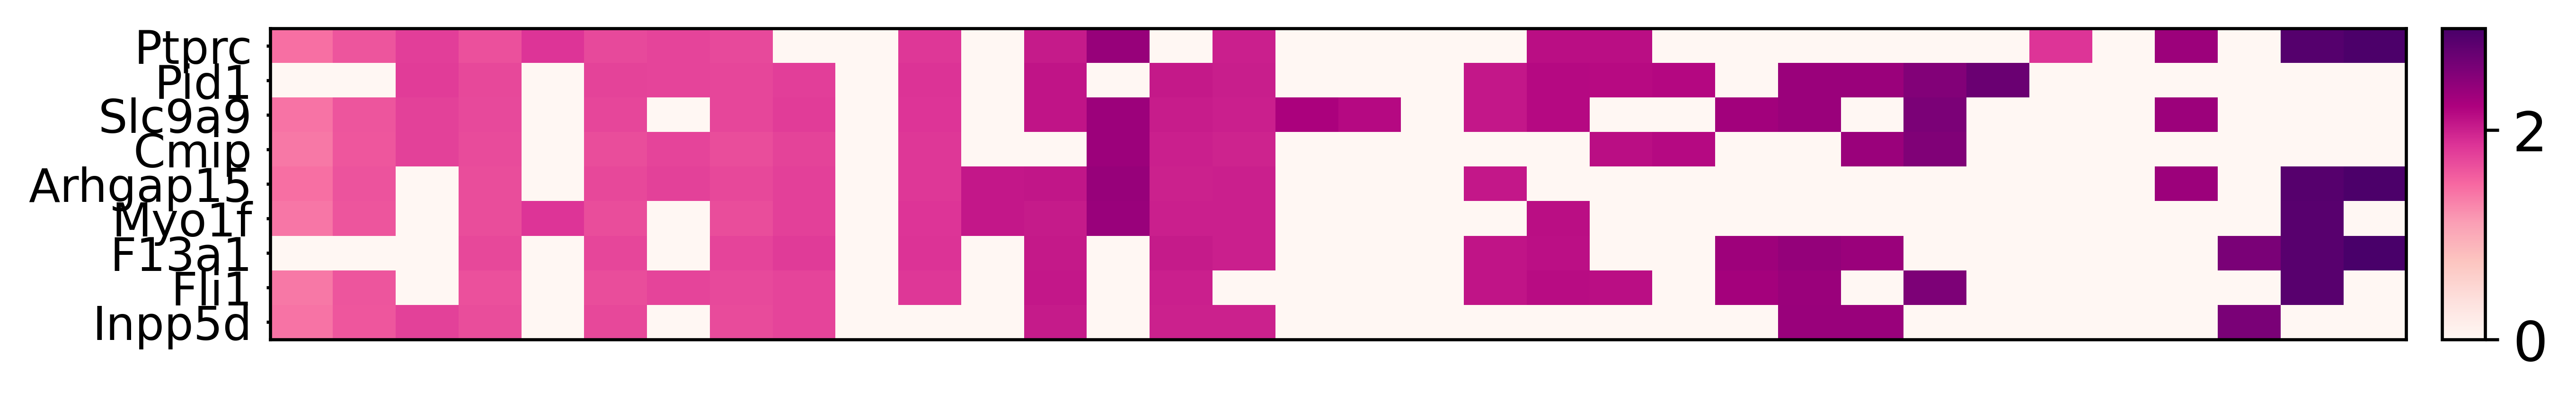

Heatmap saved to plots/vCM3_mdx_heatmap.png
Plotting heatmap for group: vCM4


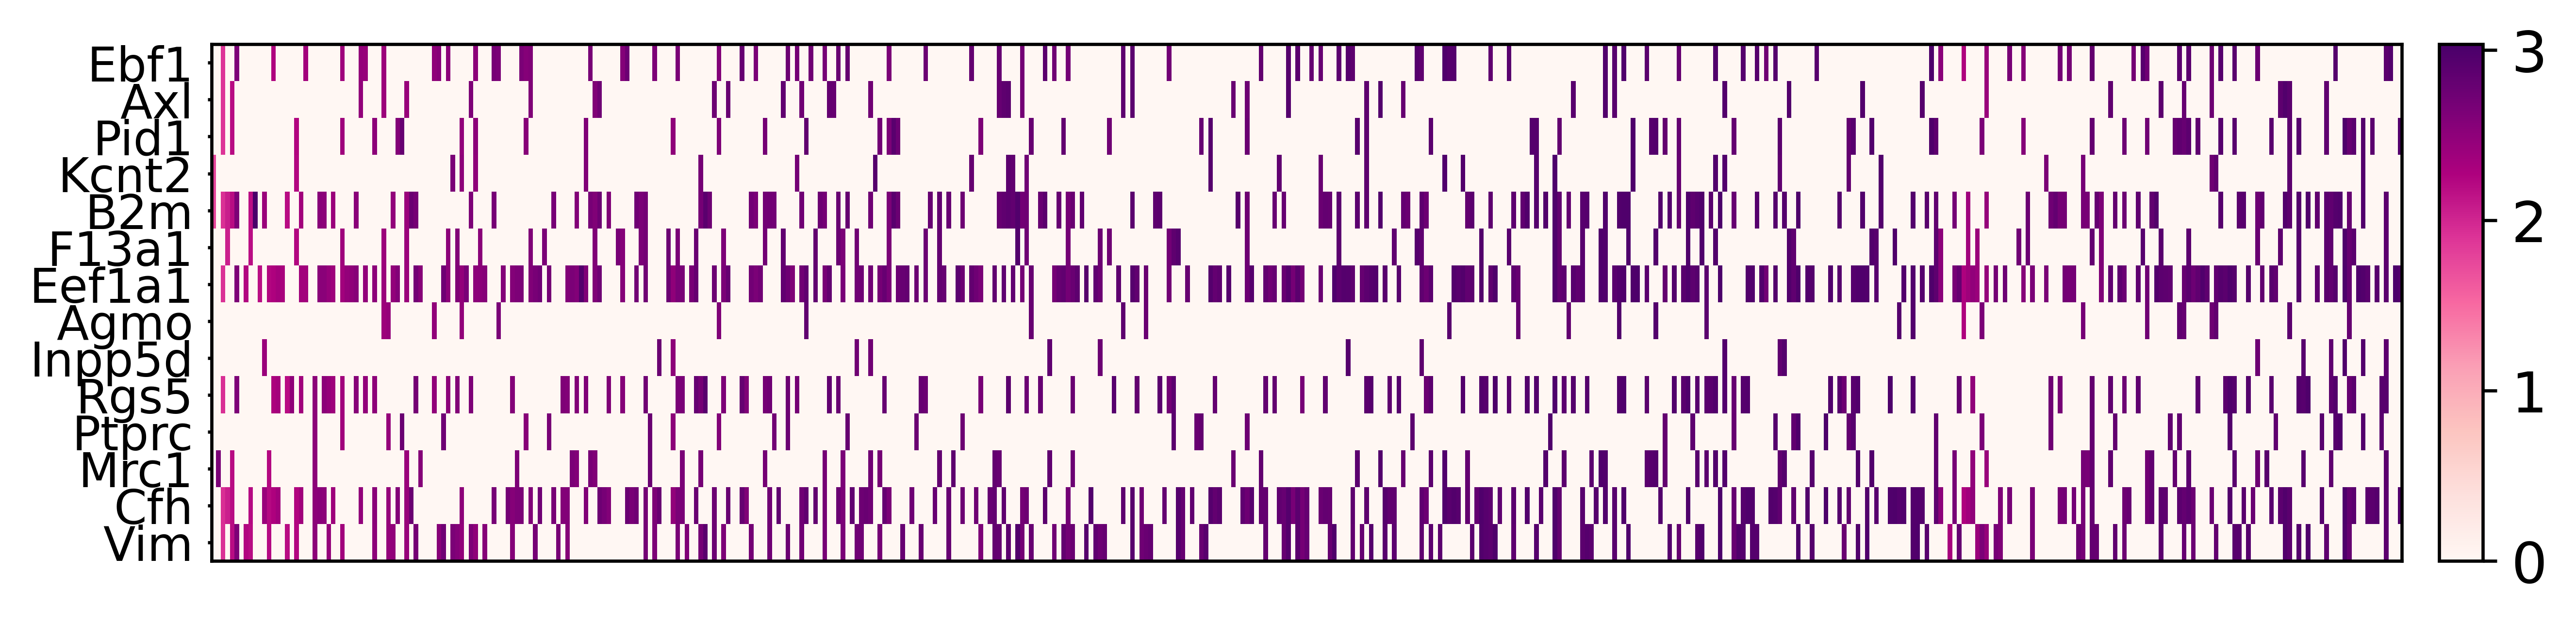

Heatmap saved to plots/vCM4_mdx_heatmap.png


In [8]:
FDR = 0.01
LOG_FOLD_CHANGE = 1.5
TOP_N_GENES = 50

def plot_heatmap(adata, group_key, groupby="cell_states", output_dir="plots"):
    if group_key not in adata.uns:
        raise ValueError(f"Group key '{group_key}' not found in adata.uns")
    
    de_results_dict = adata.uns[group_key]
    
    # Check if de_results is a dictionary of DataFrames
    if isinstance(de_results_dict, dict) and all(isinstance(v, pd.DataFrame) for v in de_results_dict.values()):
        # Concatenate all DataFrames in the dictionary
        res = pd.concat(de_results_dict.values(), keys=de_results_dict.keys(), names=['cell_states', 'index'])
    else:
        raise ValueError(f"Unexpected format for differential expression results in adata.uns['{group_key}']")
    
    required_columns = ['gene_id', 'log_fold_change', 'p_value', 'FDR']
    for col in required_columns:
        if col not in res.columns:
            raise KeyError(f"Expected column '{col}' not found in differential expression results.")
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    unique_groups = adata.obs[groupby].unique()

    for group in unique_groups:
        group_key_full = f'cell_states{group}'
        
        if group_key_full not in de_results_dict:
            print(f"No results found for group: {group}")
            continue

        print(f"Plotting heatmap for group: {group}")
        
        # Filter results for the current group
        group_res = de_results_dict[group_key_full]
        
        filtered_res = group_res[
            (group_res["FDR"] < FDR) & (abs(group_res["log_fold_change"]) > LOG_FOLD_CHANGE)
        ].sort_values(by=["log_fold_change"], ascending=False)
        
        # Get top genes for the current cell state
        top_genes = filtered_res.head(TOP_N_GENES)
        
        markers = list(top_genes['gene_id'].unique())

        if len(markers) == 0:
            print(f"No significant genes found for group: {group}")
            continue
        
        adata_group = adata[adata.obs[groupby] == group].copy()
        adata_group = adata_group[:, adata_group.var_names.isin(markers)]
        
        # Ensure that markers are displayed correctly
        filename = f"{group}_mdx_heatmap.png"
        filepath = os.path.join(output_dir, filename)

        sc.pl.heatmap(
            adata_group,
            var_names=markers,
            groupby=groupby,
            swap_axes=True,
            show=True,
        )
        
        plt.title(f"Heatmap - {group}_mdx")
        plt.ylabel("Gene Names") 
        plt.savefig(filepath)
        print(f"Heatmap saved to {filepath}")
        plt.close()

# Call the function
plot_heatmap(adata, group_key="MAST_results")

## Checking vcm1 DE

In [9]:
vcm1_data = adata[adata.obs['cell_states'] == 'vCM1']
print("vCM1 raw counts shape:", vcm1_data.shape)
vcm1_summary = vcm1_data.obs['n_counts'].describe()
print("vCM1 summary statistics:\n", vcm1_summary)

if 'MAST_results' in adata.uns:
    de_results = adata.uns['MAST_results']
    if 'cell_statesvCM1' in de_results:
        print("vCM1 DE results found.")
        vcm1_de_results = de_results['cell_statesvCM1']
        print(vcm1_de_results.head())
    else:
        print("No DE results found for vCM1.")
else:
    print("MAST_results not found in AnnData object.")


thresholds = {
    'p_value': 0.05,
    'fold_change': 2
}
print("DE analysis thresholds:", thresholds)

vCM1 raw counts shape: (838, 13468)
vCM1 summary statistics:
 count      838.000000
mean     10653.103353
std       2736.331488
min       4017.184300
25%       8901.619908
50%      11282.850938
75%      12459.890807
max      17549.169595
Name: n_counts, dtype: float64
No DE results found for vCM1.
DE analysis thresholds: {'p_value': 0.05, 'fold_change': 2}


In [10]:
def find_de_MAST(sca, target_cell_state):
    print("Finding differentially expressed genes for cell state:", target_cell_state)
    
    robjects.r('''
    library(MAST)
    library(data.table)
    
    find_de <- function(sca, target_cell_state) {
        zlmCond <- zlm(~ n_genes_per_cell + cell_states, sca)
        summaryCond <- summary(zlmCond, doLRT = TRUE)
        summaryDt <- summaryCond$datatable
        
        results <- list()
        
        cell_state_lfc <- summaryDt[contrast == target_cell_state & component == 'logFC', .(primerid, coef)]
        cell_state_p <- summaryDt[contrast == target_cell_state & component == 'H', .(primerid, `Pr(>Chisq)`)]
        tmp <- merge(cell_state_lfc, cell_state_p, by='primerid')
        tmp$log_fold_change <- tmp$coef / log(2)
        tmp$FDR <- p.adjust(tmp$`Pr(>Chisq)`, 'fdr')
        tmp$cell_states <- target_cell_state
        
        # Remove extra columns if any before renaming
        tmp <- tmp[, .(primerid, log_fold_change, `Pr(>Chisq)`, FDR, cell_states)]
            
        colnames(tmp) <- c('gene_id', 'log_fold_change', 'p_value', 'FDR', 'cell_states')
        
        results[[target_cell_state]] <- tmp
        
        results <- lapply(results, na.omit)
        return(results)
    }
    ''')

    print("Differentially expressed genes found.")

    result = robjects.r['find_de'](sca, target_cell_state)
    return result

target_cell_state = 'vCM1'

de_results_vcm1 = find_de_MAST(sca, target_cell_state)

if target_cell_state in de_results_vcm1:
    de_results_vcm1_df = pandas2ri.rpy2py(de_results_vcm1[target_cell_state])

    if de_results_vcm1_df.empty:
        print(f"No differential expression results found for {target_cell_state}.")
    else:
        output_file = f'de_results_mdxscid_{target_cell_state}.csv'
        de_results_vcm1_df.to_csv(output_file, index=False)
        print(f"Differentially expressed genes for {target_cell_state} saved to {output_file}.")
else:
    print(f"No results found for {target_cell_state}.")


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: The melt generic in data.table has been passed a array and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is superseded and is no longer actively developed, and this redirection is now deprecated. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace, i.e. reshape2::melt(coefAndCI). In the next version, this warning will become an error. 

R[write to console]: 2: The melt generic in data.table has been passed a list and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is superseded and is no longer actively developed, and this redirection is now deprecated. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace, i.e. reshape2::melt(lfc). In the next version, this warning will b

Finding differentially expressed genes for cell state: vCM1
Differentially expressed genes found.


R[write to console]: 
Done!

R[write to console]: Combining coefficients and standard errors

R[write to console]: Calculating log-fold changes

R[write to console]: Calculating likelihood ratio tests

R[write to console]: Refitting on reduced model...

R[write to console]: 
Done!

R[write to console]: Refitting on reduced model...

R[write to console]: 
Done!

R[write to console]: Refitting on reduced model...

R[write to console]: 
Done!

R[write to console]: Refitting on reduced model...

R[write to console]: 
Done!



No results found for vCM1.
